# NLP: Sentiment Analysis

To tackle this problem I'll make a classifier that will use a pre-trained BERT. I'll control most of my constants and other parameters from the config file which returns a dictionary. 

##### Imports & Config

In [2]:
# install transformers, quietly
!pip install -qq -q transformers

In [3]:
# garbage
import gc

# configuration file 
from pyfiles.config import make_config

# load & clean the data
from pyfiles.utils import extract_data, load_clean_data

# data loader 
from pyfiles.utils import data2loader

# data analysis 
from pyfiles.exploredata import data_info
from pyfiles.exploredata import max_seq_length

# model
from pyfiles.model import BertFeels

# trainer 
from pyfiles.trainer import train_model
# eval
from pyfiles.eval import eval_one_epoch

# predicting 
from pyfiles.predict import make_final_predictions

#torch 
from torch.nn import CrossEntropyLoss
from torch.cuda import empty_cache
from torch.optim import AdamW

# data splitting 
from sklearn.model_selection import train_test_split

# transformerss!
from transformers import BertTokenizer, get_linear_schedule_with_warmup

In [4]:
# assign my configurations
config_dict = make_config()

# also loading the tokenizer already 
tokenizer = BertTokenizer.from_pretrained(config_dict['PRE_TRAINED_MODEL'])

##### Extract & Load Data

In [5]:
# extracting the zip file 
extract_data(zip_file = config_dict['DATA'],
             dir_to_make = config_dict['DATA_DIR'],
             remove_zip=False)

# list of dataframes with the loaded data 
df_list = load_clean_data(data_dir=config_dict['DATA_DIR'])

Extracted ./dataset.zip to ./data


##### Exploratory Data Analysis (EDA)

Here I will have a quick overview of the data, taking a look at both the training and the testing dataset. I will look at: 
- Number of instances
- Number of empty (null) or NaNs
- Class (im)balance

TESTING 

Number of examples = 359

Number of empty values = 0

Random Tweet Sample:
Label: 0.0
Tweet: Just got mcdonalds goddam those eggs make me sick. O yeah Laker up date go lakers. Not much of an update? Well it's true so suck it



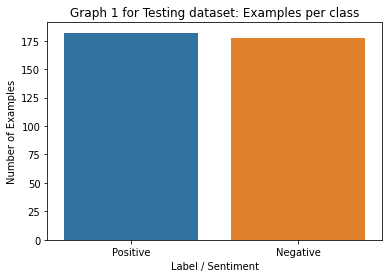

label
1.0    50.696379
0.0    49.303621
dtype: float64 

TRAINING 

Number of examples = 13000

Number of empty values = 0

Random Tweet Sample:
Label: 0
Tweet: @twista202 I still haven't read the 9th&amp;10th Princess diaries  Saving Francesca made me cry at the end. Hmm those are easy books.



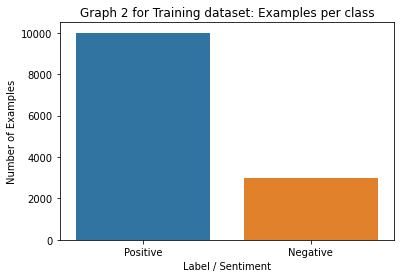

label
1    76.923077
0    23.076923
dtype: float64 



In [6]:
# overview - some sample information about the data
data_info(df_list,
          data_split=['Testing','Training'],
          random_sample=True,
          visualize=True)

Finding the maximum sequence length in the corpus

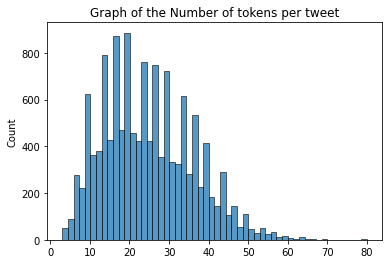

                  0
count  13359.000000
mean      24.716895
std       11.411275
min        3.000000
25%       16.000000
50%       23.000000
75%       33.000000
max       80.000000

The max len in the entire dataset is 80, 200 difference from initial guess


In [7]:
# it will give a distribution of the tokens and return the max length as well. 
# Counts the total (training + test) datapoints
max_len = max_seq_length(df_list,tokenizer,visualize=True,return_stats=True)
# Compared to the initial guess how many tokens am I off?
print(f"\nThe max len in the entire dataset is {max_len}, {abs(config_dict['OLD_MAX_LENGTH']-max_len)} difference from initial guess")

##### Dataset & DataLoaders

The tabular data needs to be processed correctly when being passed through BERT, as well as having the right dimensions when stepping through a model. Here the dataset will be created when calling the "make_data_loader" for each variable

In [18]:
# separate dataframes
df_test, df_train = df_list 

# splitting the initial training dataset into a train and validation one using a val split of 20% to validate during the training procedure
df_train, df_val = train_test_split(df_train,
                                    test_size=config_dict['VAL_SIZE'],
                                    random_state=config_dict['RANDOM_STATE'])

In [19]:
# Dataset with DataLoader
# Training
train_loader = data2loader(dataframe=df_train,
                           tokenizer=tokenizer,
                           max_length=config_dict['MAX_LENGTH'],
                           batch_size=config_dict['BATCH_SIZE'])

# Validation 
val_loader = data2loader(dataframe=df_val,
                           tokenizer=tokenizer,
                           max_length=config_dict['MAX_LENGTH'],
                           batch_size=config_dict['BATCH_SIZE'])

# Testing
test_loader = data2loader(dataframe=df_test,
                           tokenizer=tokenizer,
                           max_length=config_dict['MAX_LENGTH'],
                           batch_size=config_dict['BATCH_SIZE'])

##### Model, Optimizer, Scheduler & Loss Function

In [20]:
# instantiate the model and send to device 
model = BertFeels(config_dict['NUM_CLASSES'])
model = model.to(config_dict['DEVICE'])

# Optimizer 
optimizer = AdamW(model.parameters(),
                  lr=config_dict['LEARNING_RATE'])

# Scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(train_loader) * config_dict['EPOCHS']) # Total number of steps 

# Criteria - Loss Function
criterion = CrossEntropyLoss().to(config_dict['DEVICE'])

# just in case clean cache & garbage
empty_cache()
gc.collect()

227

##### Training & Saving of the model

Training of the model as well as an extra validation step included to have some feedback and save the best performing model. Model saving can be turned on or off in the config file as well.



In [21]:
# Training the model with feedback 
# batch steps will be shown to have some feedback as well as a validation loop 
history = train_model(model        = model,
                      train_loader = train_loader,
                      val_loader   = val_loader,
                      optimizer    = optimizer, 
                      scheduler    = scheduler, 
                      criteria     = criterion, 
                      df_train     = df_train,
                      df_val       = df_val,
                      epochs       = config_dict['EPOCHS'],
                      device       = config_dict['DEVICE'],
                      verbose      = config_dict['VERBOSE_STEP'],
                      save_model   = config_dict['SAVE_MODEL'])


~BATCH STEP~ 1: ACCURACY: 0.0003846153846153846 LOSS: 1.1682099103927612

~BATCH STEP~ 101: ACCURACY: 0.11634615384615385 LOSS: 0.5361779630184174

~BATCH STEP~ 201: ACCURACY: 0.24259615384615385 LOSS: 0.4720298321315305

~BATCH STEP~ 301: ACCURACY: 0.3729807692307692 LOSS: 0.4398237024480322

~BATCH STEP~ 401: ACCURACY: 0.50125 LOSS: 0.42340079720998347

~BATCH STEP~ 501: ACCURACY: 0.6322115384615384 LOSS: 0.4137903733138077

~BATCH STEP~ 601: ACCURACY: 0.7624038461538462 LOSS: 0.40803769197990614

TRAINING -- EPOCH: 1 ACCURACY: 0.8254807692307692 LOSS: 0.4067910624180849

VALIDATION -- EPOCH: 1 ACCURACY: 0.8588461538461538 LOSS: 0.34033791035230904

~BATCH STEP~ 1: ACCURACY: 0.0011538461538461537 LOSS: 0.4262120723724365

~BATCH STEP~ 101: ACCURACY: 0.13375 LOSS: 0.3121995550423565

~BATCH STEP~ 201: ACCURACY: 0.27403846153846156 LOSS: 0.2828406347378866

~BATCH STEP~ 301: ACCURACY: 0.41346153846153844 LOSS: 0.27176638817618853

~BATCH STEP~ 401: ACCURACY: 0.5538461538461539 LOSS: 0

##### Testing the model + Metrics

The model will be tested as well as the reporting of the metrics will happen. 
The following metrics & graphs are shown: 
- Accuracy, Loss,
- Precision, Recall, F-1 & Support
- Confusion Matrix, ROC & PR Curve

In [23]:
# just in case
empty_cache()
gc.collect()

170


The Metrics Reported: 

-->Training Accuracy & Loss: 



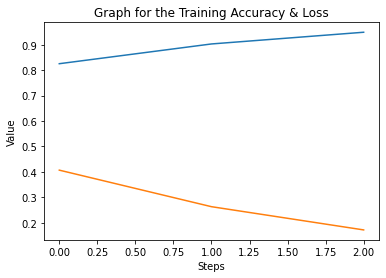


-->Validation Accuracy & Loss: 



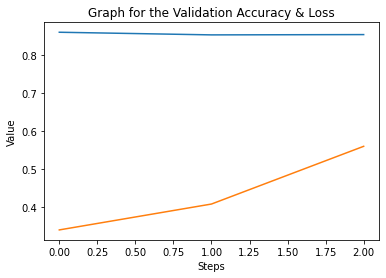

              precision    recall  f1-score   support

    Negative       0.89      0.63      0.74       177
    Positive       0.72      0.92      0.81       182

    accuracy                           0.78       359
   macro avg       0.80      0.78      0.77       359
weighted avg       0.80      0.78      0.77       359


--> Confusion Matrix: 



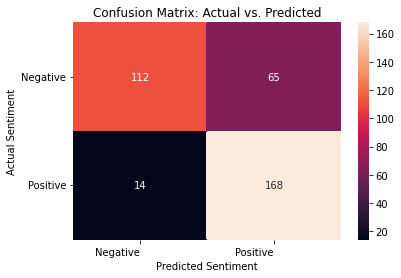


--> ROC Curve: 



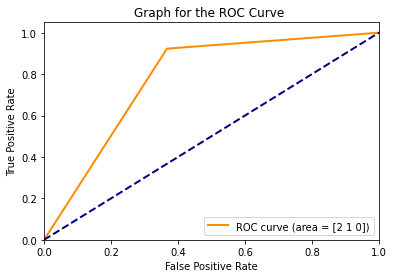


--> PR Curve: 



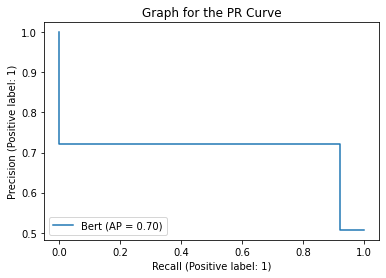

In [24]:
# this will run the evaluation & return metrics 
make_final_predictions(history, model, test_loader, criterion)

This is a classification task, so looking solely at accuracy is not a good indicator. The confusion matrix, roc and pr curve should help understand what is happening with the model. For example looking at the confusion matrix we can see that the model has problems really predicting whether something is negative or not. Out of all the negatives it predicted 65 times wrongly, which is about ~36%. This can also be traced back to the imbalance of the dataset initially. 

For a comparisson of the different runs and their corresponding metrics can be found here:


- https://wandb.ai/walzter/IOMED-NLP-TEST/reports/Reporting-Metrics--VmlldzoxNTI3NzA0?accessToken=rrqaxmzaoa26r6c4qlkpccerx29sbm2057ngz0p1byigt0dq3tyyfa5ts6rhmas6


The tracking initially was done with Wandb, and then to submit all the wandb usages were commented off so that it run without a problem. 

In [26]:
# getting the final test accuracy
test_acc, _ = eval_one_epoch(test_loader, 
                            model, 
                            criterion, 
                            config_dict['DEVICE'], 
                            num_batches=len(df_test))
# printing it 
print(test_acc.item())

0.7688022284122563
